In [1]:
%load_ext autoreload
%autoreload 2

In [91]:
from dataset import PathMNIST
import torchvision.transforms as transforms
import numpy as np

In [92]:
trainset = PathMNIST(split="train", download=False, transform=transforms.ToTensor())

In [93]:
trainset = PathMNIST(split="train", download=False)

In [114]:
mean = np.array([0.,0.,0.])
std = np.array([0.,0.,0.])
for i in range(len(trainset)):
    x = np.array(trainset[i][0])
    mean += np.mean(x, axis=(0,1))

mean /= len(trainset)

In [120]:
mean

array([188.83897503, 135.91045926, 179.98635682])

In [121]:
mean / 256

array([0.73765225, 0.53090023, 0.70307171])

In [116]:
for i in range(len(trainset)):
    x = np.array(trainset[i][0])
    for j in range(3):
        std[j] += np.mean((x[..., j] - mean[j])**2)

std = np.sqrt(std / len(trainset))

In [119]:
std

array([31.53896524, 45.07444572, 31.72982184])

In [122]:
std / 256

array([0.12319908, 0.17607205, 0.12394462])

In [42]:
from functools import partial
from typing import Sequence, Tuple, Union

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as VisionF
from lightning.pytorch.callbacks import Callback, ModelCheckpoint
from torch import Tensor
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import CIFAR10
from torchvision.models.resnet import resnet18
from torchvision.utils import make_grid

batch_size = 32
num_workers = 0  # to run notebook on CPU
max_epochs = 200
z_dim = 128

In [44]:
class BarlowTwinsTransform:
    def __init__(self, train=True, input_height=224, gaussian_blur=True, jitter_strength=1.0, normalize=None):
        self.input_height = input_height
        self.gaussian_blur = gaussian_blur
        self.jitter_strength = jitter_strength
        self.normalize = normalize
        self.train = train

        color_jitter = transforms.ColorJitter(
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.2 * self.jitter_strength,
        )

        color_transform = [transforms.RandomApply([color_jitter], p=0.8), transforms.RandomGrayscale(p=0.2)]

        if self.gaussian_blur:
            kernel_size = int(0.1 * self.input_height)
            if kernel_size % 2 == 0:
                kernel_size += 1

            color_transform.append(transforms.RandomApply([transforms.GaussianBlur(kernel_size=kernel_size)], p=0.5))

        self.color_transform = transforms.Compose(color_transform)

        if normalize is None:
            self.final_transform = transforms.ToTensor()
        else:
            self.final_transform = transforms.Compose([transforms.ToTensor(), normalize])

        self.transform = transforms.Compose(
            [
                transforms.RandomResizedCrop(self.input_height),
                transforms.RandomHorizontalFlip(p=0.5),
                self.color_transform,
                self.final_transform,
            ]
        )

        self.finetune_transform = None
        if self.train:
            self.finetune_transform = transforms.Compose(
                [
                    transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ]
            )
        else:
            self.finetune_transform = transforms.ToTensor()

    def __call__(self, sample):
        return self.transform(sample), self.transform(sample), self.finetune_transform(sample)

In [45]:
def cifar10_normalization():
    normalize = transforms.Normalize(
        mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]]
    )
    return normalize


train_transform = BarlowTwinsTransform(
    train=True, input_height=32, gaussian_blur=False, jitter_strength=0.5, normalize=cifar10_normalization()
)
train_dataset = CIFAR10(root=".", train=True, download=True, transform=train_transform)

val_transform = BarlowTwinsTransform(
    train=False, input_height=32, gaussian_blur=False, jitter_strength=0.5, normalize=cifar10_normalization()
)
val_dataset = CIFAR10(root=".", train=False, download=True, transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

100%|██████████| 170498071/170498071 [00:15<00:00, 11346196.83it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [54]:
train_dataset[0][0][-1].shape

torch.Size([3, 32, 32])

In [124]:
import os
import motti

from functools import partial
from typing import Sequence, Tuple, Union

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.transforms.functional as VisionF

import lightning as L
from lightning.pytorch.callbacks import Callback, ModelCheckpoint
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet18
from torchvision.utils import make_grid
from torchmetrics.functional import accuracy

# self define
from args import opts
from augmentation import BarlowTwinsTransform, pathmnist_normalization

from dataset import PathMNIST

train_transform = BarlowTwinsTransform(
    train=True, 
    input_height=opts.img_size, 
    gaussian_blur=False, jitter_strength=0.5, 
    normalize=pathmnist_normalization()
)

val_transform = BarlowTwinsTransform(
    train=False, 
    input_height=opts.img_size, 
    gaussian_blur=False, jitter_strength=0.5, 
    normalize=pathmnist_normalization()
)

train_dataset = PathMNIST(
    split="train", download=False, 
    transform=train_transform
)

val_dataset = PathMNIST(
    split="val", download=False, 
    transform=val_transform
)


train_loader = DataLoader(
    train_dataset, batch_size=opts.batch_size, 
    shuffle=True, num_workers=opts.num_workers, 
    drop_last=True
)

val_loader = DataLoader(
    val_dataset, batch_size=opts.batch_size, 
    shuffle=False, num_workers=opts.num_workers, 
    drop_last=True
)


usage: ipykernel_launcher.py [-h] [--batch_size BATCH_SIZE]
                             [--num_workers NUM_WORKERS]
                             [--device_num DEVICE_NUM] [--height HEIGHT]
                             [--weight WEIGHT] [--img_size IMG_SIZE]
                             [--processor_config PROCESSOR_CONFIG]
                             [--vit_config VIT_CONFIG] [--metadata METADATA]
                             [--ckpt CKPT] [--ckpt_dir CKPT_DIR]
                             [--log_dir LOG_DIR] [--img_root IMG_ROOT]
                             [--lr LR] [--max_epochs MAX_EPOCHS] [--fast]
                             [--accumulate_grad_batches ACCUMULATE_GRAD_BATCHES]
                             [--model_config MODEL_CONFIG] [--info INFO]
ipykernel_launcher.py: error: argument --fast: ignored explicit argument '/home/lupin/.local/share/jupyter/runtime/kernel-v2-30956guum3N5fZjjL.json'


AttributeError: 'tuple' object has no attribute 'tb_frame'

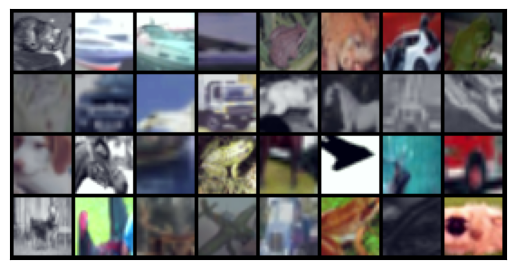

In [55]:
for batch in val_loader:
    (img1, img2, _), label = batch
    break

img_grid = make_grid(img1, normalize=True)


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = VisionF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    

show(img_grid)

In [56]:
class BarlowTwinsLoss(nn.Module):
    def __init__(self, batch_size, lambda_coeff=5e-3, z_dim=128):
        super().__init__()

        self.z_dim = z_dim
        self.batch_size = batch_size
        self.lambda_coeff = lambda_coeff

    def off_diagonal_ele(self, x):
        # taken from: https://github.com/facebookresearch/barlowtwins/blob/main/main.py
        # return a flattened view of the off-diagonal elements of a square matrix
        n, m = x.shape
        assert n == m
        return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

    def forward(self, z1, z2):
        # N x D, where N is the batch size and D is output dim of projection head
        z1_norm = (z1 - torch.mean(z1, dim=0)) / torch.std(z1, dim=0)
        z2_norm = (z2 - torch.mean(z2, dim=0)) / torch.std(z2, dim=0)

        cross_corr = torch.matmul(z1_norm.T, z2_norm) / self.batch_size

        on_diag = torch.diagonal(cross_corr).add_(-1).pow_(2).sum()
        off_diag = self.off_diagonal_ele(cross_corr).pow_(2).sum()

        return on_diag + self.lambda_coeff * off_diag

In [125]:
encoder

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [57]:
encoder = resnet18()

# for CIFAR10, replace the first 7x7 conv with smaller 3x3 conv and remove the first maxpool
encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
encoder.maxpool = nn.MaxPool2d(kernel_size=1, stride=1)

# replace classification fc layer of Resnet to obtain representations from the backbone
encoder.fc = nn.Identity()

In [144]:
X = torch.randn((1,3,1024,1024))

In [145]:
Y = encoder(X)

In [146]:
Y.shape

torch.Size([1, 512])

In [58]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=2048, output_dim=128):
        super().__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=True),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim, bias=False),
        )

    def forward(self, x):
        return self.projection_head(x)

In [59]:
def fn(warmup_steps, step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    else:
        return 1.0


def linear_warmup_decay(warmup_steps):
    return partial(fn, warmup_steps)

In [60]:
class BarlowTwins(L.LightningModule):
    def __init__(
        self,
        encoder,
        encoder_out_dim,
        num_training_samples,
        batch_size,
        lambda_coeff=5e-3,
        z_dim=128,
        learning_rate=1e-4,
        warmup_epochs=10,
        max_epochs=200,
    ):
        super().__init__()

        self.encoder = encoder
        self.projection_head = ProjectionHead(input_dim=encoder_out_dim, hidden_dim=encoder_out_dim, output_dim=z_dim)
        self.loss_fn = BarlowTwinsLoss(batch_size=batch_size, lambda_coeff=lambda_coeff, z_dim=z_dim)

        self.learning_rate = learning_rate
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs

        self.train_iters_per_epoch = num_training_samples // batch_size

    def forward(self, x):
        return self.encoder(x)

    def shared_step(self, batch):
        (x1, x2, _), _ = batch

        z1 = self.projection_head(self.encoder(x1))
        z2 = self.projection_head(self.encoder(x2))

        return self.loss_fn(z1, z2)

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log("val_loss", loss, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        warmup_steps = self.train_iters_per_epoch * self.warmup_epochs

        scheduler = {
            "scheduler": torch.optim.lr_scheduler.LambdaLR(
                optimizer,
                linear_warmup_decay(warmup_steps),
            ),
            "interval": "step",
            "frequency": 1,
        }

        return [optimizer], [scheduler]

In [61]:
class OnlineFineTuner(Callback):
    def __init__(
        self,
        encoder_output_dim: int,
        num_classes: int,
    ) -> None:
        super().__init__()

        self.optimizer: torch.optim.Optimizer

        self.encoder_output_dim = encoder_output_dim
        self.num_classes = num_classes

    def on_fit_start(self, trainer: L.Trainer, pl_module: L.LightningModule) -> None:
        # add linear_eval layer and optimizer
        pl_module.online_finetuner = nn.Linear(self.encoder_output_dim, self.num_classes).to(pl_module.device)
        self.optimizer = torch.optim.Adam(pl_module.online_finetuner.parameters(), lr=1e-4)

    def extract_online_finetuning_view(
        self, batch: Sequence, device: Union[str, torch.device]
    ) -> Tuple[Tensor, Tensor]:
        (_, _, finetune_view), y = batch
        finetune_view = finetune_view.to(device)
        y = y.to(device)

        return finetune_view, y

    def on_train_batch_end(
        self,
        trainer: L.Trainer,
        pl_module: L.LightningModule,
        outputs: Sequence,
        batch: Sequence,
        batch_idx: int,
    ) -> None:
        x, y = self.extract_online_finetuning_view(batch, pl_module.device)

        with torch.no_grad():
            feats = pl_module(x)

        feats = feats.detach()
        preds = pl_module.online_finetuner(feats)
        loss = F.cross_entropy(preds, y)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        acc = accuracy(F.softmax(preds, dim=1), y, task="multiclass", num_classes=10)
        pl_module.log("online_train_acc", acc, on_step=True, on_epoch=False)
        pl_module.log("online_train_loss", loss, on_step=True, on_epoch=False)

    def on_validation_batch_end(
        self,
        trainer: L.Trainer,
        pl_module: L.LightningModule,
        outputs: Sequence,
        batch: Sequence,
        batch_idx: int,
    ) -> None:
        x, y = self.extract_online_finetuning_view(batch, pl_module.device)

        with torch.no_grad():
            feats = pl_module(x)

        feats = feats.detach()
        preds = pl_module.online_finetuner(feats)
        loss = F.cross_entropy(preds, y)

        acc = accuracy(F.softmax(preds, dim=1), y, task="multiclass", num_classes=10)
        pl_module.log("online_val_acc", acc, on_step=False, on_epoch=True, sync_dist=True)
        pl_module.log("online_val_loss", loss, on_step=False, on_epoch=True, sync_dist=True)

In [62]:
encoder_out_dim = 512

model = BarlowTwins(
    encoder=encoder,
    encoder_out_dim=encoder_out_dim,
    num_training_samples=len(train_dataset),
    batch_size=batch_size,
    z_dim=z_dim,
)

online_finetuner = OnlineFineTuner(encoder_output_dim=encoder_out_dim, num_classes=10)
checkpoint_callback = ModelCheckpoint(every_n_epochs=100, save_top_k=-1, save_last=True)

trainer = L.Trainer(
    max_epochs=max_epochs,
    accelerator="auto",
    devices=1,
    callbacks=[online_finetuner, checkpoint_callback],
)

# uncomment this to train the model
# this is done for the tutorial so that the notebook compiles
# trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit()

In [2]:
import torch

In [1]:
x = torch.randn((2,9))

NameError: name 'torch' is not defined